# Pipeline de Modélisation ML pour la Surveillance des Ressources Serveur
Ce notebook Jupyter adapte les scripts Python précédents (`prepare_data.py`, `train_prophet.py`, `train_isolation_forest.py`, `evaluate_prophet.py`, `evaluate_isolation_forest.py`) pour une utilisation interactive.
    
**Objectifs :**
    1.  **Préparer les données** : Charger, nettoyer, rééchantillonner et diviser les données de métriques brutes.
    2.  **Entraîner les modèles** : Entraîner un modèle de prévision (Prophet) et un modèle de détection d'anomalies (Isolation Forest).
    3.  **Évaluer les modèles** : Évaluer les performances des modèles sur un jeu de test.
    4.  **Visualiser les résultats** : Générer des graphiques pour les prévisions et les anomalies détectées.
    
**Structure du Notebook :**
   *   Configuration et Imports
   *   Étape 1 : Préparation des Données
   *   Étape 2 : Entraînement du Modèle de Prévision (Prophet)
   *   Étape 3 : Entraînement du Modèle de Détection d'Anomalies (Isolation Forest)
   *   Étape 4 : Évaluation du Modèle Prophet
   *   Étape 5 : Évaluation du Modèle Isolation Forest
   *   Conclusion et Prochaines Étapes

## Configuration et Imports
    
Définition des variables de configuration (chemins, paramètres) et importation des bibliothèques nécessaires.

In [3]:
# --- Variables de Configuration --- 

# Chemins des fichiers d'entrée (données brutes CSV)
VMSTAT_RAW_PATH = "D:\\projet\\trainning\\data\\vmstat_metrics.csv"
IOSTAT_RAW_PATH = "D:\\projet\\trainning\\data\\iostat_metrics.csv"
NETSTAT_RAW_PATH = "D:\\projet\\trainning\\data\\netstat_metrics.csv"
PROCESS_RAW_PATH = "D:\\projet\\trainning\\data\\process_metrics.csv" # Non utilisé dans ce pipeline initial, mais disponible

# Répertoire pour les données préparées
PREPARED_DATA_DIR = "D:\\projet\\trainning\\prepared_data_notebook"

# Répertoire pour les modèles entraînés
TRAINED_MODELS_DIR = "D:\\projet\\trainning\\trained_models_notebook"

# Répertoire pour les résultats d'évaluation
EVALUATION_RESULTS_DIR = "D:\\projet\\trainning\\evaluation_results_notebook"

# Paramètres de préparation des données
TIME_COL = 'timestamp' # Nom de la colonne de temps dans les CSV bruts
RESAMPLE_FREQ = '5min' # Fréquence de rééchantillonnage
AGG_METHOD = 'mean' # Méthode d'agrégation
TEST_SIZE = 0.2 # Proportion pour le jeu de test

# Métriques à utiliser pour Prophet (exemple)
PROPHET_METRIC = 'us'
PROPHET_INPUT_FILE = VMSTAT_RAW_PATH # Fichier contenant la métrique Prophet

# Métriques à utiliser pour Isolation Forest (combinées)
# In Configuration Section (top of notebook)
ISO_FOREST_FEATURES = [
    'us', 'sy', 'idle', 'avm', 'fre',  # Added memory metrics
    'tps', 'ipkts', 'opkts'            # Existing metrics
]

ISO_FOREST_INPUT_FILES = {
    'us': VMSTAT_RAW_PATH,
    'sy': VMSTAT_RAW_PATH,
    'idle': VMSTAT_RAW_PATH,
    'avm': VMSTAT_RAW_PATH,  # Assumes these exist in vmstat
    'fre': VMSTAT_RAW_PATH,
    'tps': IOSTAT_RAW_PATH,
    'ipkts': NETSTAT_RAW_PATH,
    'opkts': NETSTAT_RAW_PATH
}

# Paramètres Isolation Forest
ISO_FOREST_N_ESTIMATORS = 100
ISO_FOREST_CONTAMINATION = 'auto' # ou un float comme 0.05
ISO_FOREST_RANDOM_STATE = 42

# --- Imports --- 

import pandas as pd
import numpy as np
import os
import joblib
import logging
# from sklearn.model_selection import train_test_split # Incorrect pour les séries temporelles
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go # Pour affichage direct
import plotly.io as pio

# Configuration du logging (optionnel dans un notebook, print peut suffire)
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Remplacé par des print pour la clarté dans le notebook

# Configuration pour affichage Plotly dans divers environnements
pio.renderers.default = "vscode" # ou 'notebook', 'colab', 'kaggle', 'vscode', etc.

# Configuration pour affichage Matplotlib inline
%matplotlib inline

# Création des répertoires si nécessaire
os.makedirs(PREPARED_DATA_DIR, exist_ok=True)
os.makedirs(TRAINED_MODELS_DIR, exist_ok=True)
os.makedirs(EVALUATION_RESULTS_DIR, exist_ok=True)

print(f"Répertoires créés/vérifiés :")
print(f"- Données préparées : {PREPARED_DATA_DIR}")
print(f"- Modèles entraînés : {TRAINED_MODELS_DIR}")
print(f"- Résultats évaluation : {EVALUATION_RESULTS_DIR}")

d:\projet\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Répertoires créés/vérifiés :
- Données préparées : D:\projet\trainning\prepared_data_notebook
- Modèles entraînés : D:\projet\trainning\trained_models_notebook
- Résultats évaluation : D:\projet\trainning\evaluation_results_notebook


## Étape 1 : Préparation des Données
    
Cette section contient la fonction pour charger, nettoyer, rééchantillonner et diviser les données brutes en jeux d'entraînement et de test.

In [4]:
def prepare_data_notebook(input_filepath, output_dir, time_col, value_cols,
                            resample_freq='5min', agg_method='mean', test_size=0.2, 
                            save_output=True, file_prefix=None):
    """Prépare les données pour l'entraînement (version notebook).
    
    Args:
        input_filepath (str): Chemin vers le fichier CSV d'entrée.
        output_dir (str): Répertoire pour sauvegarder les fichiers (si save_output=True).
        time_col (str): Nom de la colonne de timestamp.
        value_cols (list): Liste des colonnes de valeurs à traiter.
        resample_freq (str): Fréquence de resampling.
        agg_method (str): Méthode d'agrégation ('mean', 'sum', 'max', 'min').
        test_size (float): Proportion pour le jeu de test.
        save_output (bool): Si True, sauvegarde les fichiers train/test CSV.
        file_prefix (str, optional): Préfixe pour les noms de fichiers sauvegardés. 
                                     Si None, utilise le nom du fichier d'entrée.
                                     
    Returns:
        tuple: (train_df, test_df) ou (None, None) en cas d'erreur.
    """

    print(f"--- Préparation des données pour {input_filepath} ---")

    # --- 1. Chargement --- 
    try:
        df = pd.read_csv(input_filepath)
        print(f"Chargé {df.shape[0]} lignes initiales.")

        # Convertir la colonne de temps, gestion des erreurs
        try:
            df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        except Exception as e:
             print(f"Avertissement : Erreur initiale de parsing de date ({e}), tentative avec format mixte...")
             try:
                 df[time_col] = pd.to_datetime(df[time_col], format='mixed', errors='coerce')
             except Exception as e2:
                 print(f"ERREUR : Échec final du parsing de la colonne de temps {time_col}: {e2}")
                 return None, None

        # Supprimer les lignes où la date n'a pas pu être parsée
        initial_rows = len(df)
        df.dropna(subset=[time_col], inplace=True)
        if len(df) < initial_rows:
            print(f"Avertissement : {initial_rows - len(df)} lignes supprimées (erreurs de date).")

        if df.empty:
            print("ERREUR : DataFrame vide après gestion des erreurs de date.")
            return None, None

        df.set_index(time_col, inplace=True)
        df.sort_index(inplace=True)
        print(f"Index temporel défini et trié. Période: {df.index.min()} à {df.index.max()}")

    except FileNotFoundError:
        print(f"ERREUR : Fichier non trouvé : {input_filepath}")
        return None, None
    except Exception as e:
        print(f"ERREUR lors du chargement initial : {e}")
        return None, None

    # --- 2. Sélection et Vérification des Colonnes --- 
    if not isinstance(value_cols, list):
        value_cols = [value_cols] # Assurer que c'est une liste

    available_cols = [col for col in value_cols if col in df.columns]
    missing_req_cols = [col for col in value_cols if col not in df.columns]
    if missing_req_cols:
        print(f"Avertissement : Colonnes requises manquantes : {missing_req_cols}. Elles seront ignorées.")
    if not available_cols:
        print(f"ERREUR : Aucune des colonnes spécifiées ({value_cols}) n'est présente dans le fichier.")
        return None, None
        
    df_processed = df[available_cols].copy()
    print(f"Colonnes sélectionnées : {available_cols}")

    # --- 3. Resampling et Agrégation --- 
    print(f"Resampling à {resample_freq} avec méthode {agg_method}...")
    try:
        if agg_method == 'mean':
            df_resampled = df_processed.resample(resample_freq).mean()
        elif agg_method == 'sum':
            df_resampled = df_processed.resample(resample_freq).sum()
        elif agg_method == 'max':
            df_resampled = df_processed.resample(resample_freq).max()
        elif agg_method == 'min':
            df_resampled = df_processed.resample(resample_freq).min()
        else:
            print(f"ERREUR : Méthode d'agrégation non supportée : {agg_method}")
            return None, None
    except Exception as e:
        print(f"ERREUR lors du resampling : {e}")
        return None, None

    # --- 4. Gestion des Valeurs Manquantes (post-resampling) --- 
    initial_nan = df_resampled.isnull().sum().sum()
    if initial_nan > 0:
        print(f"Avertissement : {initial_nan} NaNs après resampling. Interpolation temporelle...")
        df_resampled.interpolate(method='time', inplace=True)
        df_resampled.fillna(method='ffill', inplace=True)
        df_resampled.fillna(method='bfill', inplace=True)
        final_nan = df_resampled.isnull().sum().sum()
        if final_nan > 0:
             print("ERREUR : Des NaNs persistent après interpolation/fill.")
             # return None, None # Ou continuer avec les NaNs restants ? Pour l'instant on continue.
        else:
             print("Valeurs manquantes traitées.")

    # --- 5. Division Train/Test (Chronologique) --- 
    print(f"Division Train/Test (Test size: {test_size:.0%})...")
    split_index = int(len(df_resampled) * (1 - test_size))
    if split_index <= 0 or split_index >= len(df_resampled):
        print("ERREUR : Impossible de diviser, jeu de données trop petit ou test_size invalide.")
        return None, None

    train_df = df_resampled.iloc[:split_index].copy() # Utiliser .copy() pour éviter SettingWithCopyWarning
    test_df = df_resampled.iloc[split_index:].copy()
    print(f"Taille Train: {len(train_df)}, Taille Test: {len(test_df)}")

    # --- 6. Sauvegarde (Optionnelle) --- 
    if save_output:
        try:
            if file_prefix is None:
                base_name = os.path.splitext(os.path.basename(input_filepath))[0]
                file_prefix = base_name # Utilise le nom du fichier source par défaut
                
            train_filename = os.path.join(output_dir, f"{file_prefix}_train.csv")
            test_filename = os.path.join(output_dir, f"{file_prefix}_test.csv")

            train_df.to_csv(train_filename)
            test_df.to_csv(test_filename)
            print(f"Données d'entraînement sauvegardées : {train_filename}")
            print(f"Données de test sauvegardées : {test_filename}")
        except Exception as e:
            print(f"ERREUR lors de la sauvegarde des fichiers : {e}")
            # Ne pas retourner None ici, car les dataframes sont peut-être valides en mémoire

    print(f"--- Préparation terminée pour {input_filepath} ---\n")
    return train_df, test_df

### 1.1 Préparation des données pour Prophet (métrique unique)

In [5]:
# Préparer les données pour la métrique Prophet
prophet_train_df, prophet_test_df = prepare_data_notebook(
    input_filepath=PROPHET_INPUT_FILE,
    output_dir=PREPARED_DATA_DIR,
    time_col=TIME_COL,
    value_cols=[PROPHET_METRIC], # Doit être une liste
    resample_freq=RESAMPLE_FREQ,
    agg_method=AGG_METHOD,
    test_size=TEST_SIZE,
    save_output=True,
    file_prefix=f"prophet_{PROPHET_METRIC}" # Préfixe spécifique pour clarté
)

# Afficher un aperçu des données préparées (si réussi)
if prophet_train_df is not None:
    print("\nAperçu des données d'entraînement Prophet :")
    display(prophet_train_df.head())
if prophet_test_df is not None:
    print("\nAperçu des données de test Prophet :")
    display(prophet_test_df.head())

--- Préparation des données pour D:\projet\trainning\data\vmstat_metrics.csv ---
Chargé 362214 lignes initiales.
Index temporel défini et trié. Période: 2025-05-12 10:54:20.086262+00:00 à 2025-05-30 11:15:21.413999+00:00
Colonnes sélectionnées : ['us']
Resampling à 5min avec méthode mean...
Avertissement : 2286 NaNs après resampling. Interpolation temporelle...
Valeurs manquantes traitées.
Division Train/Test (Test size: 20%)...
Taille Train: 4152, Taille Test: 1038
Données d'entraînement sauvegardées : D:\projet\trainning\prepared_data_notebook\prophet_us_train.csv
Données de test sauvegardées : D:\projet\trainning\prepared_data_notebook\prophet_us_test.csv
--- Préparation terminée pour D:\projet\trainning\data\vmstat_metrics.csv ---


Aperçu des données d'entraînement Prophet :


C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\3772313508.py:99: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\3772313508.py:100: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,us
timestamp,
2025-05-12 10:50:00+00:00,63.439000
2025-05-12 10:55:00+00:00,62.508167
2025-05-12 11:00:00+00:00,61.577333
2025-05-12 11:05:00+00:00,60.646500
2025-05-12 11:10:00+00:00,64.205786



Aperçu des données de test Prophet :


,us
timestamp,
2025-05-26 20:50:00+00:00,21.594203
2025-05-26 20:55:00+00:00,21.467626
2025-05-26 21:00:00+00:00,21.354331
2025-05-26 21:05:00+00:00,21.104000
2025-05-26 21:10:00+00:00,21.608000


### 1.2 Préparation des données pour Isolation Forest (métriques multiples)

In [6]:
# Préparer les données pour chaque feature d'Isolation Forest individuellement
# puis les combiner
iso_forest_train_dfs = {}
iso_forest_test_dfs = {}
all_features_prepared = True

# Utiliser un set pour éviter de traiter le même fichier plusieurs fois si plusieurs features viennent du même fichier
unique_files_to_process = set(ISO_FOREST_INPUT_FILES.values())
temp_prepared_data = {}

for filepath in unique_files_to_process:
    # Trouver toutes les features provenant de ce fichier
    features_from_this_file = [f for f, fp in ISO_FOREST_INPUT_FILES.items() if fp == filepath and f in ISO_FOREST_FEATURES]
    if not features_from_this_file:
        continue # Aucune feature requise de ce fichier
        
    print(f"\nTraitement du fichier {filepath} pour les features: {features_from_this_file}")
    # Utiliser un préfixe basé sur le nom du fichier source
    file_base_name = os.path.splitext(os.path.basename(filepath))[0]
    train_df, test_df = prepare_data_notebook(
        input_filepath=filepath,
        output_dir=PREPARED_DATA_DIR,
        time_col=TIME_COL,
        value_cols=features_from_this_file, # Préparer toutes les features de ce fichier en une fois
        resample_freq=RESAMPLE_FREQ,
        agg_method=AGG_METHOD,
        test_size=TEST_SIZE,
        save_output=True, # Sauvegarder les fichiers intermédiaires préparés par source
        file_prefix=file_base_name 
    )
    
    if train_df is None or test_df is None:
        print(f"ERREUR : Échec de la préparation pour {filepath}. Arrêt de la préparation Isolation Forest.")
        all_features_prepared = False
        break
    else:
        # Stocker les dataframes préparés pour ce fichier source
        temp_prepared_data[filepath] = {'train': train_df, 'test': test_df}

# Combiner les features à partir des dataframes préparés
iso_forest_train_combined = None
iso_forest_test_combined = None

if all_features_prepared:
    print("\nCombinaison des features préparées pour Isolation Forest...")
    train_list_to_concat = []
    test_list_to_concat = []
    processed_features = set()

    for feature in ISO_FOREST_FEATURES:
        source_file = ISO_FOREST_INPUT_FILES.get(feature)
        if source_file and source_file in temp_prepared_data:
            # Extraire la colonne de feature spécifique du dataframe préparé correspondant
            if feature in temp_prepared_data[source_file]['train'].columns:
                train_list_to_concat.append(temp_prepared_data[source_file]['train'][[feature]])
                processed_features.add(feature) # Marquer comme traitée pour train
            if feature in temp_prepared_data[source_file]['test'].columns:
                test_list_to_concat.append(temp_prepared_data[source_file]['test'][[feature]])
                # Pas besoin de marquer pour test, car on suit train
        else:
             print(f"Avertissement: Feature '{feature}' non trouvée ou fichier source non traité.")
             
    if len(processed_features) != len(ISO_FOREST_FEATURES):
        print(f"Avertissement: Toutes les features Isolation Forest n'ont pas pu être préparées/combinées. Features manquantes: {set(ISO_FOREST_FEATURES) - processed_features}")
        
    if train_list_to_concat and test_list_to_concat:
        try:
            # Concaténer sur l'index (temps), jointure externe pour garder tous les temps
            iso_forest_train_combined = pd.concat(train_list_to_concat, axis=1, join='outer')
            iso_forest_test_combined = pd.concat(test_list_to_concat, axis=1, join='outer')
            
            # Gérer les NaNs potentiels dus à la jointure externe (si les index ne correspondent pas parfaitement)
            for df_comb in [iso_forest_train_combined, iso_forest_test_combined]:
                initial_nan = df_comb.isnull().sum().sum()
                if initial_nan > 0:
                    print(f"Avertissement: {initial_nan} NaNs après combinaison. Interpolation...")
                    df_comb.interpolate(method='time', inplace=True)
                    df_comb.fillna(method='ffill', inplace=True)
                    df_comb.fillna(method='bfill', inplace=True)
                    if df_comb.isnull().sum().sum() > 0:
                        print("ERREUR: NaNs persistants après combinaison et interpolation.")
                        # Option: df_comb.dropna(inplace=True)

            print("\nDonnées combinées pour Isolation Forest (Train) :")
            display(iso_forest_train_combined.head())
            print("\nDonnées combinées pour Isolation Forest (Test) :")
            display(iso_forest_test_combined.head())

            # Sauvegarde optionnelle des fichiers combinés
            # if save_output: # Déjà géré dans prepare_data_notebook, mais on peut sauvegarder le combiné aussi
            train_comb_path = os.path.join(PREPARED_DATA_DIR, 'iso_forest_combined_train.csv')
            test_comb_path = os.path.join(PREPARED_DATA_DIR, 'iso_forest_combined_test.csv')
            iso_forest_train_combined.to_csv(train_comb_path)
            iso_forest_test_combined.to_csv(test_comb_path)
            print(f"Données combinées sauvegardées : {train_comb_path}, {test_comb_path}")
                 
        except Exception as e:
            print(f"ERREUR lors de la combinaison finale des features : {e}")
            iso_forest_train_combined = None
            iso_forest_test_combined = None
    else:
        print("ERREUR: Aucune donnée préparée à combiner pour Isolation Forest.")

# Nettoyage des dataframes temporaires (optionnel)
del temp_prepared_data 
del train_list_to_concat
del test_list_to_concat


Traitement du fichier D:\projet\trainning\data\netstat_metrics.csv pour les features: ['ipkts', 'opkts']
--- Préparation des données pour D:\projet\trainning\data\netstat_metrics.csv ---
Chargé 755489 lignes initiales.
Index temporel défini et trié. Période: 2025-05-12 14:26:59.743837+00:00 à 2025-05-30 11:15:57.321452+00:00
Colonnes sélectionnées : ['ipkts', 'opkts']
Resampling à 5min avec méthode mean...
Avertissement : 4582 NaNs après resampling. Interpolation temporelle...
Valeurs manquantes traitées.
Division Train/Test (Test size: 20%)...
Taille Train: 4117, Taille Test: 1030


C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\3772313508.py:99: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\3772313508.py:100: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Données d'entraînement sauvegardées : D:\projet\trainning\prepared_data_notebook\netstat_metrics_train.csv
Données de test sauvegardées : D:\projet\trainning\prepared_data_notebook\netstat_metrics_test.csv
--- Préparation terminée pour D:\projet\trainning\data\netstat_metrics.csv ---


Traitement du fichier D:\projet\trainning\data\vmstat_metrics.csv pour les features: ['us', 'sy', 'idle', 'avm', 'fre']
--- Préparation des données pour D:\projet\trainning\data\vmstat_metrics.csv ---
Chargé 362214 lignes initiales.
Index temporel défini et trié. Période: 2025-05-12 10:54:20.086262+00:00 à 2025-05-30 11:15:21.413999+00:00
Colonnes sélectionnées : ['us', 'sy', 'idle', 'avm', 'fre']
Resampling à 5min avec méthode mean...
Avertissement : 11430 NaNs après resampling. Interpolation temporelle...
Valeurs manquantes traitées.
Division Train/Test (Test size: 20%)...
Taille Train: 4152, Taille Test: 1038


C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\3772313508.py:99: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\3772313508.py:100: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Données d'entraînement sauvegardées : D:\projet\trainning\prepared_data_notebook\vmstat_metrics_train.csv
Données de test sauvegardées : D:\projet\trainning\prepared_data_notebook\vmstat_metrics_test.csv
--- Préparation terminée pour D:\projet\trainning\data\vmstat_metrics.csv ---


Traitement du fichier D:\projet\trainning\data\iostat_metrics.csv pour les features: ['tps']
--- Préparation des données pour D:\projet\trainning\data\iostat_metrics.csv ---
Chargé 1636551 lignes initiales.
Index temporel défini et trié. Période: 2025-05-12 14:26:25.687593+00:00 à 2025-05-30 11:15:35.388311+00:00
Colonnes sélectionnées : ['tps']
Resampling à 5min avec méthode mean...
Avertissement : 2286 NaNs après resampling. Interpolation temporelle...
Valeurs manquantes traitées.
Division Train/Test (Test size: 20%)...
Taille Train: 4117, Taille Test: 1030
Données d'entraînement sauvegardées : D:\projet\trainning\prepared_data_notebook\iostat_metrics_train.csv
Données de test sauvegardées : D:\projet\tra

C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\3772313508.py:99: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\3772313508.py:100: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\629266239.py:78: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\629266239.py:79: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\isarhrany\AppData\Local\Temp\ipykernel_2464\629266239.py:78: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version

,us,sy,idle,avm,fre,tps,ipkts,opkts
timestamp,,,,,,,,
2025-05-12 10:50:00+00:00,63.439000,21.000000,43.000000,0.0,0.0,0.756579,3.117774e+08,4.701142e+08
2025-05-12 10:55:00+00:00,62.508167,21.000000,43.000000,0.0,0.0,0.756579,3.117774e+08,4.701142e+08
2025-05-12 11:00:00+00:00,61.577333,21.000000,43.000000,0.0,0.0,0.756579,3.117774e+08,4.701142e+08
2025-05-12 11:05:00+00:00,60.646500,21.000000,43.000000,0.0,0.0,0.756579,3.117774e+08,4.701142e+08
2025-05-12 11:10:00+00:00,64.205786,20.928571,43.857143,0.0,0.0,0.756579,3.117774e+08,4.701142e+08



Données combinées pour Isolation Forest (Test) :


,us,sy,idle,avm,fre,tps,ipkts,opkts
timestamp,,,,,,,,
2025-05-26 20:50:00+00:00,21.594203,43.601449,34.818841,947976.956522,1.183604e+06,30.465185,2.515612e+08,3.745567e+08
2025-05-26 20:55:00+00:00,21.467626,43.640288,34.964029,948082.273381,1.183460e+06,30.465185,2.515612e+08,3.745567e+08
2025-05-26 21:00:00+00:00,21.354331,43.559055,35.188976,948229.110236,1.183272e+06,30.465185,2.515612e+08,3.745567e+08
2025-05-26 21:05:00+00:00,21.104000,43.528000,35.392000,948153.352000,1.183309e+06,30.465185,2.515612e+08,3.745567e+08
2025-05-26 21:10:00+00:00,21.608000,43.336000,35.128000,948472.896000,1.182950e+06,30.465185,2.515612e+08,3.745567e+08


Données combinées sauvegardées : D:\projet\trainning\prepared_data_notebook\iso_forest_combined_train.csv, D:\projet\trainning\prepared_data_notebook\iso_forest_combined_test.csv


## Étape 2 : Entraînement du Modèle de Prévision (Prophet)
    
Entraînement du modèle Prophet sur les données préparées pour la métrique cible.

In [7]:
def train_prophet_notebook(train_df, metric_name, model_save_dir, prophet_params=None):
    """Entraîne un modèle Prophet (version notebook).
    
    Args:
        train_df (pd.DataFrame): DataFrame d'entraînement préparé (index=temps, une colonne valeur).
        metric_name (str): Nom de la métrique (utilisé pour nommer le modèle sauvegardé).
        model_save_dir (str): Répertoire où sauvegarder le modèle.
        prophet_params (dict, optional): Paramètres pour l'initialisation de Prophet.
        
    Returns:
        Prophet: Le modèle Prophet entraîné, ou None en cas d'erreur.
    """
    print(f"--- Entraînement Prophet pour la métrique : {metric_name} ---")
    
    if train_df is None or train_df.empty:
        print("ERREUR : DataFrame d'entraînement vide ou None.")
        return None
        
    # Préparer le DataFrame pour Prophet (colonnes 'ds' et 'y')
    df_prophet = train_df.reset_index() # L'index devient une colonne 'index' ou time_col
    # Renommer la colonne de temps en 'ds' et la colonne de valeur en 'y'
    time_col_name = train_df.index.name if train_df.index.name else 'index' # Trouver le nom de la colonne de temps
    if time_col_name not in df_prophet.columns:
         # Si l'index n'avait pas de nom, il s'appelle 'index' après reset_index
         if 'index' in df_prophet.columns:
             time_col_name = 'index'
         else:
             print(f"ERREUR: Impossible de trouver la colonne de temps après reset_index. Colonnes: {df_prophet.columns}")
             return None
             
    value_col_name = train_df.columns[0] # Prend la première (et unique) colonne de valeur
    df_prophet.rename(columns={time_col_name: 'ds', value_col_name: 'y'}, inplace=True)
    
    # Vérifier et supprimer le fuseau horaire si présent
    if pd.api.types.is_datetime64_any_dtype(df_prophet['ds']) and df_prophet['ds'].dt.tz is not None:
        print("Avertissement : Conversion de la colonne 'ds' en timezone-naive pour Prophet.")
        df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)
        
    df_prophet = df_prophet[['ds', 'y']] # Garder uniquement les colonnes nécessaires
    
    print(f"Données formatées pour Prophet (premières lignes) :")
    display(df_prophet.head())

    # Paramètres par défaut si non fournis
    if prophet_params is None:
        prophet_params = {
            'daily_seasonality': True,
            'weekly_seasonality': True,
            'yearly_seasonality': False, # Ajuster si nécessaire
            # 'changepoint_prior_scale': 0.05 
        }
        print(f"Utilisation des paramètres Prophet par défaut : {prophet_params}")
    else:
        print(f"Utilisation des paramètres Prophet fournis : {prophet_params}")

    model = Prophet(**prophet_params)

    # Entraînement
    try:
        print("Début de l'entraînement Prophet...")
        model.fit(df_prophet)
        print("Entraînement Prophet terminé.")
        
        # Sauvegarde du modèle
        model_filename = f"prophet_{metric_name}_model.joblib"
        model_filepath = os.path.join(model_save_dir, model_filename)
        print(f"Sauvegarde du modèle dans {model_filepath}...")
        joblib.dump(model, model_filepath)
        print("Modèle Prophet sauvegardé.")
        return model
        
    except Exception as e:
        print(f"ERREUR lors de l'entraînement ou de la sauvegarde Prophet : {e}")
        return None

In [8]:
# Entraîner le modèle Prophet
prophet_model = None
if prophet_train_df is not None:
    prophet_model = train_prophet_notebook(
        train_df=prophet_train_df,
        metric_name=PROPHET_METRIC,
        model_save_dir=TRAINED_MODELS_DIR,
        prophet_params=None # Utiliser les paramètres par défaut définis dans la fonction
    )
else:
    print("ERREUR: Impossible d'entraîner Prophet car les données d'entraînement n'ont pas été préparées correctement.")

# Afficher le modèle si entraîné
if prophet_model:
    print("\nModèle Prophet entraîné :")
    # Afficher certains paramètres internes peut être utile
    # print(prophet_model.params)
    pass # Ou afficher un message de succès simple

--- Entraînement Prophet pour la métrique : us ---
Avertissement : Conversion de la colonne 'ds' en timezone-naive pour Prophet.
Données formatées pour Prophet (premières lignes) :


,ds,y
0,2025-05-12 10:50:00,63.439000
1,2025-05-12 10:55:00,62.508167
2,2025-05-12 11:00:00,61.577333
3,2025-05-12 11:05:00,60.646500
4,2025-05-12 11:10:00,64.205786


Utilisation des paramètres Prophet par défaut : {'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': False}
Début de l'entraînement Prophet...


11:30:20 - cmdstanpy - INFO - Chain [1] start processing
11:30:22 - cmdstanpy - INFO - Chain [1] done processing


Entraînement Prophet terminé.
Sauvegarde du modèle dans D:\projet\trainning\trained_models_notebook\prophet_us_model.joblib...
Modèle Prophet sauvegardé.

Modèle Prophet entraîné :


## Étape 3 : Entraînement du Modèle de Détection d'Anomalies (Isolation Forest)
    
Entraînement du modèle Isolation Forest sur les données combinées et mises à l'échelle.

In [9]:
def train_isolation_forest_notebook(train_df, features_list, model_save_dir, 
                                    n_estimators=100, contamination='auto', random_state=42):
    """Entraîne un modèle Isolation Forest (version notebook).
    
    Args:
        train_df (pd.DataFrame): DataFrame combiné d'entraînement préparé.
        features_list (list): Liste des colonnes à utiliser comme features.
        model_save_dir (str): Répertoire où sauvegarder le modèle et le scaler.
        n_estimators (int): Nombre d'estimateurs pour Isolation Forest.
        contamination (float or 'auto'): Taux de contamination attendu.
        random_state (int): Seed pour la reproductibilité.
        
    Returns:
        tuple: (model, scaler) ou (None, None) en cas d'erreur.
    """
    print("--- Entraînement Isolation Forest ---")
    
    if train_df is None or train_df.empty:
        print("ERREUR : DataFrame d'entraînement combiné vide ou None.")
        return None, None
        
    # Vérifier si toutes les features demandées sont présentes
    missing_features = [f for f in features_list if f not in train_df.columns]
    if missing_features:
        print(f"ERREUR: Features manquantes dans le DataFrame d'entraînement : {missing_features}")
        return None, None
        
    df_features = train_df[features_list].copy() # Sélectionner et copier
    
    # 1. Mise à l'échelle
    print("Mise à l'échelle des features (StandardScaler)...")
    scaler = StandardScaler()
    try:
        scaled_features = scaler.fit_transform(df_features)
        print("Features mises à l'échelle.")
    except Exception as e:
        print(f"ERREUR lors de la mise à l'échelle : {e}")
        return None, None
        
    # 2. Entraînement Isolation Forest
    print("Initialisation et entraînement Isolation Forest...")
    iso_forest_params = {
        'n_estimators': n_estimators,
        'contamination': contamination,
        'random_state': random_state,
        'n_jobs': -1 # Utiliser tous les CPU
    }
    print(f"Paramètres Isolation Forest : {iso_forest_params}")
    
    model = IsolationForest(**iso_forest_params)
    
    try:
        model.fit(scaled_features)
        print("Entraînement Isolation Forest terminé.")
    except Exception as e:
        print(f"ERREUR lors de l'entraînement Isolation Forest : {e}")
        return None, None
        
    # 3. Sauvegarde modèle et scaler
    model_filename = "isolation_forest_combined_model.joblib"
    scaler_filename = "isolation_forest_combined_scaler.joblib"
    model_filepath = os.path.join(model_save_dir, model_filename)
    scaler_filepath = os.path.join(model_save_dir, scaler_filename)
    
    try:
        print(f"Sauvegarde du modèle dans {model_filepath}...")
        joblib.dump(model, model_filepath)
        print("Modèle sauvegardé.")
        
        print(f"Sauvegarde du scaler dans {scaler_filepath}...")
        joblib.dump(scaler, scaler_filepath)
        print("Scaler sauvegardé.")
        
        return model, scaler
        
    except Exception as e:
        print(f"ERREUR lors de la sauvegarde du modèle ou du scaler : {e}")
        return model, scaler # Retourner quand même s'ils existent en mémoire

In [10]:
# Entraîner le modèle Isolation Forest
iso_forest_model = None
iso_forest_scaler = None

if iso_forest_train_combined is not None:
    iso_forest_model, iso_forest_scaler = train_isolation_forest_notebook(
        train_df=iso_forest_train_combined,
        features_list=ISO_FOREST_FEATURES,
        model_save_dir=TRAINED_MODELS_DIR,
        n_estimators=ISO_FOREST_N_ESTIMATORS,
        contamination=ISO_FOREST_CONTAMINATION,
        random_state=ISO_FOREST_RANDOM_STATE
    )
else:
    print("ERREUR: Impossible d'entraîner Isolation Forest car les données combinées n'ont pas été préparées correctement.")

# Afficher si réussi
if iso_forest_model and iso_forest_scaler:
    print("\nModèle Isolation Forest et Scaler entraînés et sauvegardés.")
    print(iso_forest_model.get_params())
    print(iso_forest_scaler.mean_)

--- Entraînement Isolation Forest ---
Mise à l'échelle des features (StandardScaler)...
Features mises à l'échelle.
Initialisation et entraînement Isolation Forest...
Paramètres Isolation Forest : {'n_estimators': 100, 'contamination': 'auto', 'random_state': 42, 'n_jobs': -1}
Entraînement Isolation Forest terminé.
Sauvegarde du modèle dans D:\projet\trainning\trained_models_notebook\isolation_forest_combined_model.joblib...
Modèle sauvegardé.
Sauvegarde du scaler dans D:\projet\trainning\trained_models_notebook\isolation_forest_combined_scaler.joblib...
Scaler sauvegardé.

Modèle Isolation Forest et Scaler entraînés et sauvegardés.
{'bootstrap': False, 'contamination': 'auto', 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'verbose': 0, 'warm_start': False}
[4.36140881e+01 3.34572752e+01 3.66628833e+01 4.45196606e+05
 4.96482774e+05 5.41048012e+02 2.81772367e+08 4.22196067e+08]


## Étape 4 : Évaluation du Modèle Prophet
    
Évaluation du modèle Prophet sur le jeu de test, calcul des métriques et visualisation des prédictions.

In [11]:
def evaluate_prophet_notebook(model, test_df, metric_name, output_dir):
    """Évalue le modèle Prophet sur les données de test (version notebook).
    
    Args:
        model (Prophet): Le modèle Prophet entraîné.
        test_df (pd.DataFrame): DataFrame de test préparé (index=temps, une colonne valeur).
        metric_name (str): Nom de la métrique (pour nommer les sorties).
        output_dir (str): Répertoire pour sauvegarder les métriques et graphiques.
        
    Returns:
        pd.DataFrame: DataFrame contenant les prédictions et les valeurs réelles, ou None.
    """
    print(f"--- Évaluation Prophet pour : {metric_name} ---")
    
    if model is None or test_df is None or test_df.empty:
        print("ERREUR : Modèle ou données de test invalides.")
        return None

    # Préparer le DataFrame de test pour Prophet
    df_test_prophet = test_df.reset_index()
    time_col_name = test_df.index.name if test_df.index.name else 'index'
    if time_col_name not in df_test_prophet.columns:
         if 'index' in df_test_prophet.columns:
             time_col_name = 'index'
         else:
             print(f"ERREUR: Impossible de trouver la colonne de temps dans test_df après reset_index. Colonnes: {df_test_prophet.columns}")
             return None
    value_col_name = test_df.columns[0]
    df_test_prophet.rename(columns={time_col_name: 'ds', value_col_name: 'y'}, inplace=True)
    
    if pd.api.types.is_datetime64_any_dtype(df_test_prophet['ds']) and df_test_prophet['ds'].dt.tz is not None:
        df_test_prophet['ds'] = df_test_prophet['ds'].dt.tz_localize(None)
        
    df_test_prophet = df_test_prophet[['ds', 'y']]
    
    print("Génération des prédictions sur le jeu de test...")
    try:
        # Prophet a besoin d'un DataFrame avec uniquement la colonne 'ds' pour predict
        future_df = df_test_prophet[['ds']] 
        forecast = model.predict(future_df)
        print("Prédictions générées.")

        # Fusionner les prédictions avec les valeurs réelles du test set
        # Utiliser 'ds' comme clé de jointure
        eval_df = pd.merge(df_test_prophet, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')
        if eval_df.empty:
            print("ERREUR : Échec de la fusion des données réelles et prédites (eval_df vide).")
            return None

        # Calcul des métriques
        mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
        rmse = np.sqrt(mean_squared_error(eval_df["y"], eval_df["yhat"]))
        mape = mean_absolute_percentage_error(eval_df['y'], eval_df['yhat'])

        print(f"\nMétriques d'évaluation pour {metric_name} :")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAPE: {mape:.4f}")

        # Sauvegarde des métriques dans un fichier
        metrics_filepath = os.path.join(output_dir, f"prophet_{metric_name}_evaluation_metrics.txt")
        with open(metrics_filepath, 'w') as f:
            f.write(f"Evaluation Metrics for Prophet Model - {metric_name}\n")
            f.write("========================================\n")
            f.write(f"MAE: {mae:.4f}\n")
            f.write(f"RMSE: {rmse:.4f}\n")
            f.write(f"MAPE: {mape:.4f}\n")
        print(f"Métriques sauvegardées dans {metrics_filepath}")

        # Génération et sauvegarde/affichage des graphiques (Plotly HTML)
        print("Génération des graphiques d'évaluation...")
        fig_forecast = plot_plotly(model, forecast) # forecast contient déjà les données prédites
        # Ajouter les vraies valeurs au graphique pour comparaison
        fig_forecast.add_trace(go.Scatter(x=eval_df['ds'], y=eval_df['y'], mode='markers', name='Actual', marker=dict(color='red', size=4)))
        fig_components = plot_components_plotly(model, forecast)

        forecast_plot_path = os.path.join(output_dir, f"prophet_{metric_name}_forecast_plot.html")
        components_plot_path = os.path.join(output_dir, f"prophet_{metric_name}_components_plot.html")

        fig_forecast.write_html(forecast_plot_path)
        fig_components.write_html(components_plot_path)
        print(f"Graphique de prédiction sauvegardé : {forecast_plot_path}")
        print(f"Graphique des composantes sauvegardé : {components_plot_path}")
        
        # Afficher les graphiques directement dans le notebook
        print("\nAffichage des graphiques interactifs :")
        fig_forecast.show()
        fig_components.show()
        
        return eval_df # Retourner le df avec prédictions et vraies valeurs

    except Exception as e:
        print(f"ERREUR lors de l'évaluation ou de la sauvegarde Prophet : {e}")
        import traceback
        traceback.print_exc() # Afficher la trace complète de l'erreur
        return None

In [12]:
# Évaluer le modèle Prophet
prophet_eval_results = None
if prophet_model and prophet_test_df is not None:
    prophet_eval_results = evaluate_prophet_notebook(
        model=prophet_model,
        test_df=prophet_test_df,
        metric_name=PROPHET_METRIC,
        output_dir=EVALUATION_RESULTS_DIR
    )
else:
    print("ERREUR: Impossible d'évaluer Prophet car le modèle ou les données de test sont manquants.")

# Afficher un aperçu des résultats d'évaluation
if prophet_eval_results is not None:
    print("\nAperçu des résultats d'évaluation Prophet (prédictions vs réel) :")
    display(prophet_eval_results.head())

--- Évaluation Prophet pour : us ---
Génération des prédictions sur le jeu de test...
Prédictions générées.

Métriques d'évaluation pour us :
  MAE: 6.7484
  RMSE: 10.2181
  MAPE: 0.2340
Métriques sauvegardées dans D:\projet\trainning\evaluation_results_notebook\prophet_us_evaluation_metrics.txt
Génération des graphiques d'évaluation...
Graphique de prédiction sauvegardé : D:\projet\trainning\evaluation_results_notebook\prophet_us_forecast_plot.html
Graphique des composantes sauvegardé : D:\projet\trainning\evaluation_results_notebook\prophet_us_components_plot.html

Affichage des graphiques interactifs :



Aperçu des résultats d'évaluation Prophet (prédictions vs réel) :


,ds,y,yhat,yhat_lower,yhat_upper
0,2025-05-26 20:50:00,21.594203,16.435948,9.682596,23.607258
1,2025-05-26 20:55:00,21.467626,16.429405,9.235566,23.942891
2,2025-05-26 21:00:00,21.354331,16.427153,9.134449,22.750041
3,2025-05-26 21:05:00,21.104000,16.429034,9.326766,23.520895
4,2025-05-26 21:10:00,21.608000,16.434853,9.041537,23.851214


## Étape 5 : Évaluation du Modèle Isolation Forest
   
Application du modèle Isolation Forest sur le jeu de test, identification et visualisation des anomalies.

In [13]:
def evaluate_isolation_forest_notebook(model, scaler, test_df, features_list, output_dir):
    """Applique le modèle Isolation Forest aux données de test et visualise les anomalies (version notebook).
    
    Args:
        model (IsolationForest): Le modèle Isolation Forest entraîné.
        scaler (StandardScaler): Le scaler entraîné.
        test_df (pd.DataFrame): DataFrame de test combiné préparé.
        features_list (list): Liste des features utilisées (doit correspondre à l'entraînement).
        output_dir (str): Répertoire pour sauvegarder les résultats et graphiques.
        
    Returns:
        pd.DataFrame: DataFrame de test avec les prédictions d'anomalies, ou None.
    """
    print("--- Évaluation Isolation Forest ---")
    
    if model is None or scaler is None or test_df is None or test_df.empty:
        print("ERREUR : Modèle, scaler ou données de test invalides.")
        return None

    # Vérifier si les features du scaler correspondent à celles demandées
    if not all(f in test_df.columns for f in features_list):
        print(f"ERREUR: Features manquantes dans test_df: {set(features_list) - set(test_df.columns)}")
        return None
    if list(scaler.feature_names_in_) != features_list:
        print(f"Avertissement: L'ordre/liste des features du scaler ({list(scaler.feature_names_in_)}) \n"
              f"ne correspond pas exactement à features_list ({features_list}). \n"
              f"Utilisation de l'ordre du scaler.")
        features_to_use = list(scaler.feature_names_in_)
    else:
        features_to_use = features_list
        
    test_df_ordered = test_df[features_to_use].copy()
    
    print("Mise à l'échelle des données de test...")
    try:
        scaled_test_features = scaler.transform(test_df_ordered)
    except Exception as e:
        print(f"ERREUR lors de la mise à l'échelle des données de test : {e}")
        return None

    print("Prédiction des anomalies sur le jeu de test...")
    try:
        predictions = model.predict(scaled_test_features)
        anomaly_scores = model.score_samples(scaled_test_features) # Score négatif, plus bas = plus anormal

        # Ajouter les prédictions et scores au DataFrame original (avec l'index temporel)
        test_df_results = test_df.copy()
        test_df_results['anomaly_prediction'] = predictions # -1 pour anomalie, 1 pour normal
        test_df_results['anomaly_score'] = anomaly_scores

        num_anomalies = (predictions == -1).sum()
        percent_anomalies = (num_anomalies / len(predictions)) * 100
        print(f"Nombre d'anomalies détectées : {num_anomalies} ({percent_anomalies:.2f}%)")

    except Exception as e:
        print(f"ERREUR lors de la prédiction des anomalies : {e}")
        return None

    # Sauvegarde du DataFrame avec les anomalies
    output_csv_path = os.path.join(output_dir, "anomaly_detection_results.csv")
    try:
        test_df_results.to_csv(output_csv_path)
        print(f"Résultats de détection (avec scores) sauvegardés dans {output_csv_path}")
    except Exception as e:
        print(f"ERREUR lors de la sauvegarde des résultats CSV : {e}")

    # Visualisation (Matplotlib)
    print("Génération du graphique de visualisation des anomalies...")
    try:
        n_features = len(features_to_use)
        fig, axes = plt.subplots(n_features, 1, figsize=(15, 4 * n_features), sharex=True)
        if n_features == 1:
            axes = [axes] # Rendre itérable si une seule feature

        anomalies = test_df_results[test_df_results['anomaly_prediction'] == -1]

        for i, feature in enumerate(features_to_use):
            ax = axes[i]
            ax.plot(test_df_results.index, test_df_results[feature], label=f"{feature} (Normal)", color='blue', alpha=0.7, linewidth=1)
            # Marquer les anomalies
            ax.scatter(anomalies.index, anomalies[feature], color='red', label='Anomalie', s=50, marker='x', zorder=5)
            ax.set_ylabel(feature)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.6)
            # Formatter l'axe des x pour les dates
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            # Améliorer la lisibilité des ticks
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

        # Utiliser l'index du DataFrame pour les limites x si possible
        if not test_df_results.empty:
             axes[-1].set_xlim(test_df_results.index.min(), test_df_results.index.max())
             
        axes[-1].set_xlabel("Timestamp") # Label X seulement sur le dernier subplot
        fig.suptitle("Détection d'Anomalies avec Isolation Forest (sur données de test)", fontsize=16, y=1.02) # Ajuster y pour éviter chevauchement
        plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajuster pour le titre

        plot_filepath = os.path.join(output_dir, "anomaly_detection_plot.png")
        plt.savefig(plot_filepath, bbox_inches='tight')
        print(f"Graphique de détection d'anomalies sauvegardé dans {plot_filepath}")
        plt.show() # Afficher directement dans le notebook
        plt.close(fig) # Fermer la figure pour libérer la mémoire
        
        return test_df_results

    except Exception as e:
        print(f"ERREUR lors de la génération des graphiques : {e}")
        import traceback
        traceback.print_exc()
        return test_df_results # Retourner quand même les résultats si le graphique échoue

--- Évaluation Isolation Forest ---
Mise à l'échelle des données de test...
Prédiction des anomalies sur le jeu de test...
Nombre d'anomalies détectées : 793 (76.40%)
Résultats de détection (avec scores) sauvegardés dans D:\projet\trainning\evaluation_results_notebook\anomaly_detection_results.csv
Génération du graphique de visualisation des anomalies...
Graphique de détection d'anomalies sauvegardé dans D:\projet\trainning\evaluation_results_notebook\anomaly_detection_plot.png


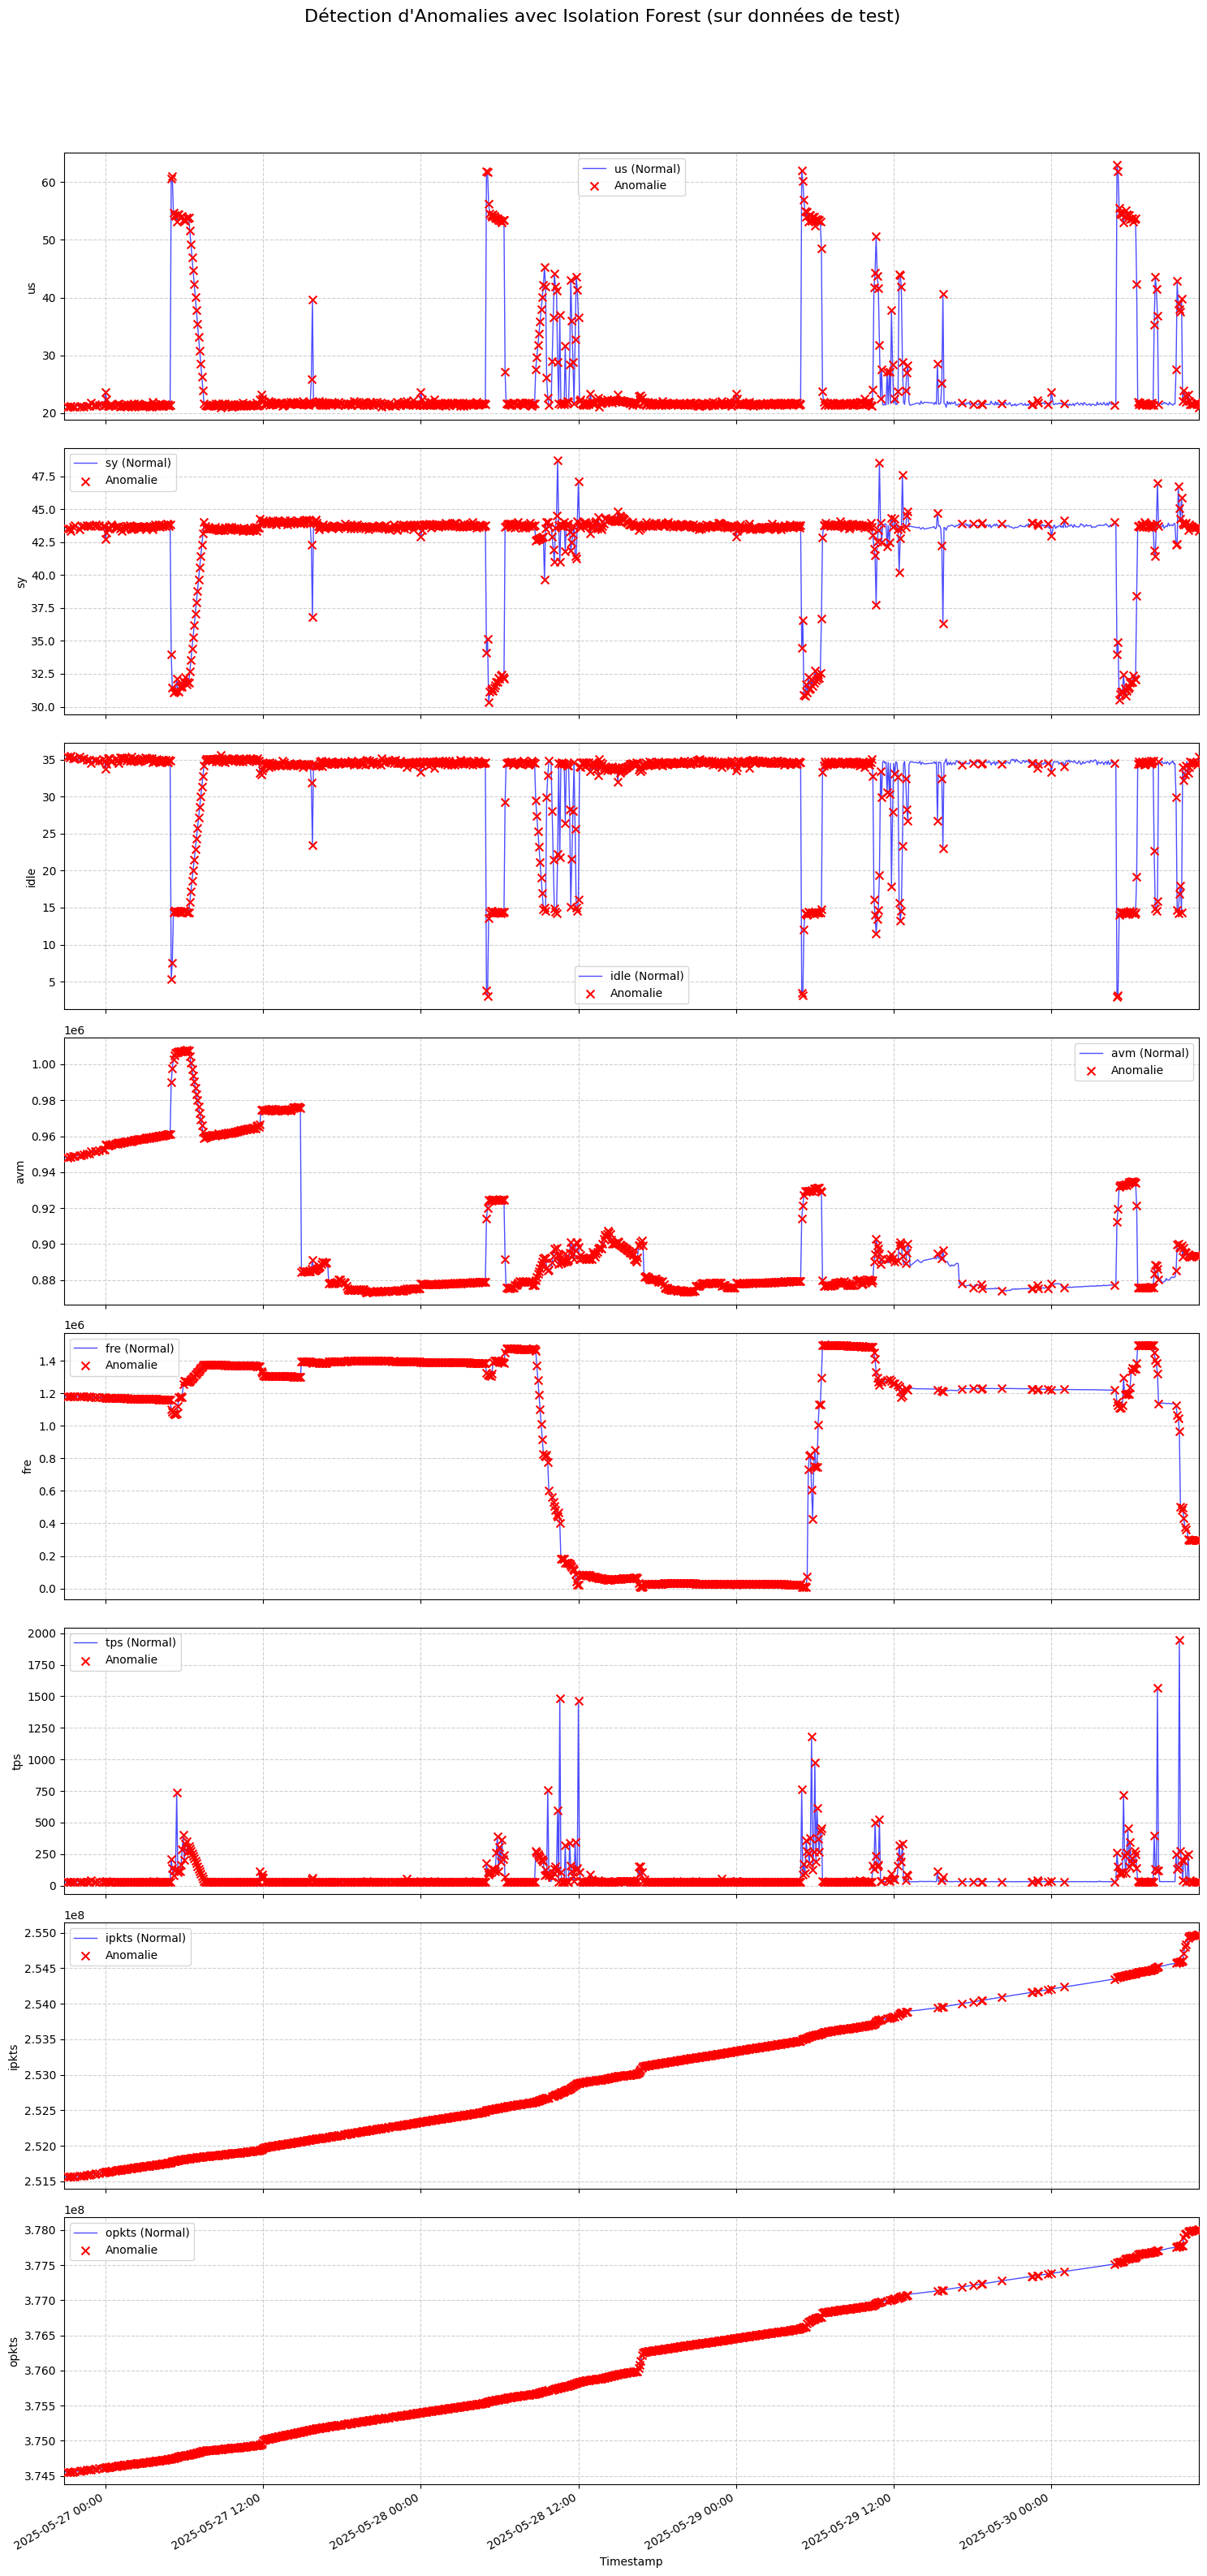


Aperçu des résultats d'évaluation Isolation Forest (avec prédictions d'anomalies) :


,us,sy,idle,avm,fre,tps,ipkts,opkts,anomaly_prediction,anomaly_score
timestamp,,,,,,,,,,
2025-05-26 20:50:00+00:00,21.594203,43.601449,34.818841,947976.956522,1.183604e+06,30.465185,2.515612e+08,3.745567e+08,1,-0.491059
2025-05-26 20:55:00+00:00,21.467626,43.640288,34.964029,948082.273381,1.183460e+06,30.465185,2.515612e+08,3.745567e+08,1,-0.495835
2025-05-26 21:00:00+00:00,21.354331,43.559055,35.188976,948229.110236,1.183272e+06,30.465185,2.515612e+08,3.745567e+08,1,-0.495974
2025-05-26 21:05:00+00:00,21.104000,43.528000,35.392000,948153.352000,1.183309e+06,30.465185,2.515612e+08,3.745567e+08,-1,-0.501705
2025-05-26 21:10:00+00:00,21.608000,43.336000,35.128000,948472.896000,1.182950e+06,30.465185,2.515612e+08,3.745567e+08,1,-0.498844


In [14]:
# Évaluer le modèle Isolation Forest
iso_forest_eval_results = None
if iso_forest_model and iso_forest_scaler and iso_forest_test_combined is not None:
    iso_forest_eval_results = evaluate_isolation_forest_notebook(
        model=iso_forest_model,
        scaler=iso_forest_scaler,
        test_df=iso_forest_test_combined,
        features_list=ISO_FOREST_FEATURES,
        output_dir=EVALUATION_RESULTS_DIR
    )
else:
    print("ERREUR: Impossible d'évaluer Isolation Forest car modèle, scaler ou données de test sont manquants.")

# Afficher un aperçu des résultats d'évaluation
if iso_forest_eval_results is not None:
    print("\nAperçu des résultats d'évaluation Isolation Forest (avec prédictions d'anomalies) :")
    display(iso_forest_eval_results.head())

## Conclusion et Prochaines Étapes
    
Ce notebook a démontré le pipeline complet depuis la préparation des données jusqu'à l'évaluation des modèles Prophet et Isolation Forest.
    
**Résultats Clés :**
   *   Les métriques d'évaluation de Prophet (MAE, RMSE, MAPE) sont disponibles dans le fichier texte et affichées ci-dessus.
   *   Les graphiques de prévision Prophet montrent la performance visuelle du modèle.
   *   Le modèle Isolation Forest a identifié un certain nombre de points comme anormaux (voir pourcentage ci-dessus et graphique).
   *   Les résultats détaillés (prédictions, scores d'anomalie) sont sauvegardés dans les fichiers CSV.
    
   **Prochaines Étapes Possibles :**
   *   **Affinage des modèles :** Tester différents hyperparamètres pour Prophet et Isolation Forest.
   *   **Intégration Backend :** Intégrer les modèles sauvegardés (`.joblib`) dans l'application Django pour faire des prédictions/détections en temps réel ou batch via une API.
   *   **Intégration Frontend :** Créer les composants Angular pour appeler l'API backend et afficher les prévisions et les anomalies.
   *   **Exploration d'autres modèles :** Tester d'autres algorithmes (ex: ARIMA, LSTM pour la prévision ; Autoencodeurs, LOF pour les anomalies).
   *   **Feature Engineering :** Créer de nouvelles features (ex: moyennes mobiles, dérivées) pour améliorer les performances.

In [15]:
def train_improved_prophet_notebook(train_df, metric_name, model_save_dir, prophet_params=None):
    """Enhanced Prophet training with better default parameters and validation."""
    
    print(f"--- Entraînement Prophet Amélioré pour : {metric_name} ---")
    
    if train_df is None or train_df.empty:
        print("ERREUR : DataFrame d'entraînement vide ou None.")
        return None
        
    # Prepare DataFrame for Prophet
    df_prophet = train_df.reset_index()
    time_col_name = train_df.index.name if train_df.index.name else 'index'
    if time_col_name not in df_prophet.columns:
        if 'index' in df_prophet.columns:
            time_col_name = 'index'
        else:
            print(f"ERREUR: Impossible de trouver la colonne de temps. Colonnes: {df_prophet.columns}")
            return None
             
    value_col_name = train_df.columns[0]
    df_prophet.rename(columns={time_col_name: 'ds', value_col_name: 'y'}, inplace=True)
    
    # Handle timezone
    if pd.api.types.is_datetime64_any_dtype(df_prophet['ds']) and df_prophet['ds'].dt.tz is not None:
        print("Conversion timezone-naive pour Prophet.")
        df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)
        
    df_prophet = df_prophet[['ds', 'y']]
    
    # Enhanced default parameters based on system metrics characteristics
    if prophet_params is None:
        # Analyze data characteristics to set better parameters
        data_range = df_prophet['ds'].max() - df_prophet['ds'].min()
        
        prophet_params = {
            'daily_seasonality': True,
            'weekly_seasonality': True if data_range.days >= 14 else False,
            'yearly_seasonality': False,  # Usually not relevant for system metrics
            'changepoint_prior_scale': 0.1,  # More sensitive to trend changes
            'seasonality_prior_scale': 0.1,  # More flexible seasonality
            'holidays_prior_scale': 0.1,
            'seasonality_mode': 'multiplicative',  # Often better for system metrics
            'interval_width': 0.95,  # Wider prediction intervals
            'mcmc_samples': 0,  # Faster training
        }
        
        # Add custom seasonalities for system metrics
        print(f"Paramètres Prophet optimisés : {prophet_params}")
    else:
        print(f"Paramètres Prophet fournis : {prophet_params}")

    model = Prophet(**prophet_params)
    
    # Add custom seasonalities for system monitoring
    model.add_seasonality(name='hourly', period=1, fourier_order=8)  # Hourly patterns
    
    # Add regressors for system context if available
    # This could include business hours, maintenance windows, etc.
    
    try:
        print("Début de l'entraînement Prophet...")
        model.fit(df_prophet)
        print("Entraînement terminé.")
        
        # Cross-validation for better evaluation
        print("Validation croisée...")
        from prophet.diagnostics import cross_validation, performance_metrics
        
        # Adjust cv parameters based on data size
        cv_horizon = min(pd.Timedelta('1 days'), data_range * 0.1)
        cv_initial = max(pd.Timedelta('3 days'), data_range * 0.7)
        cv_period = min(pd.Timedelta('12 hours'), cv_horizon * 0.5)
        
        df_cv = cross_validation(model, 
                               initial=cv_initial, 
                               period=cv_period, 
                               horizon=cv_horizon)
        df_p = performance_metrics(df_cv)
        print("Métriques de validation croisée:")
        print(df_p[['mape', 'mae', 'rmse']].mean())
        
        # Save model
        model_filename = f"prophet_{metric_name}_improved_model.joblib"
        model_filepath = os.path.join(model_save_dir, model_filename)
        print(f"Sauvegarde dans {model_filepath}...")
        joblib.dump(model, model_filepath)
        print("Modèle sauvegardé.")
        
        return model
        
    except Exception as e:
        print(f"ERREUR lors de l'entraînement : {e}")
        return None

def create_crash_prediction_features(df_combined):
    """Create features specifically for crash prediction."""
    
    df_features = df_combined.copy()
    
    # Rate-based features (more sensitive to sudden changes)
    for col in ['us', 'sy', 'idle', 'avm', 'fre']:
        if col in df_features.columns:
            # Rate of change
            df_features[f'{col}_rate'] = df_features[col].diff()
            # Rolling variance (instability indicator)
            df_features[f'{col}_variance'] = df_features[col].rolling(window=10).var()
            # Percentage change
            df_features[f'{col}_pct_change'] = df_features[col].pct_change()
    
    # Network traffic rates (for ipkts question)
    for col in ['ipkts', 'opkts']:
        if col in df_features.columns:
            # Packets per second (rate)
            df_features[f'{col}_rate'] = df_features[col].diff()
            # Traffic burst detection
            df_features[f'{col}_burst'] = (df_features[f'{col}_rate'] > 
                                         df_features[f'{col}_rate'].rolling(window=20).mean() + 
                                         2 * df_features[f'{col}_rate'].rolling(window=20).std()).astype(int)
    
    # Memory pressure indicators
    if 'avm' in df_features.columns and 'fre' in df_features.columns:
        df_features['memory_pressure'] = df_features['avm'] / (df_features['avm'] + df_features['fre'])
        df_features['memory_pressure_rate'] = df_features['memory_pressure'].diff()
    
    # CPU overload indicators
    cpu_cols = ['us', 'sy']
    if all(col in df_features.columns for col in cpu_cols):
        df_features['total_cpu_usage'] = df_features[cpu_cols].sum(axis=1)
        df_features['cpu_overload'] = (df_features['total_cpu_usage'] > 80).astype(int)
    
    # System instability score
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    variance_cols = [col for col in numeric_cols if '_variance' in col]
    if variance_cols:
        df_features['instability_score'] = df_features[variance_cols].sum(axis=1)
    
    return df_features

def train_crash_prediction_model(train_df, model_save_dir):
    """Train a model specifically for crash prediction."""
    
    print("--- Entraînement Modèle de Prédiction de Crash ---")
    
    # Create enhanced features
    df_features = create_crash_prediction_features(train_df)
    
    # Create crash labels (you'll need to define what constitutes a "pre-crash" state)
    # This is an example - adjust based on your crash criteria
    df_features['crash_risk'] = 0
    
    # Define crash risk conditions
    conditions = [
        (df_features.get('total_cpu_usage', 0) > 95),  # Very high CPU
        (df_features.get('memory_pressure', 0) > 0.9),  # Very low free memory
        (df_features.get('instability_score', 0) > df_features.get('instability_score', pd.Series([0])).quantile(0.95)),  # High instability
    ]
    
    # Mark high-risk periods
    for condition in conditions:
        df_features.loc[condition, 'crash_risk'] = 1
    
    # Select features for training
    feature_cols = [col for col in df_features.columns 
                   if col.endswith(('_rate', '_variance', '_pct_change', '_burst')) 
                   or col in ['memory_pressure', 'total_cpu_usage', 'instability_score']]
    
    # Remove rows with NaN (from diff operations)
    df_clean = df_features.dropna()
    
    if df_clean.empty:
        print("ERREUR: Pas de données après nettoyage.")
        return None
    
    X = df_clean[feature_cols]
    y = df_clean['crash_risk']
    
    print(f"Features utilisées: {feature_cols}")
    print(f"Taux de crash risk: {y.mean():.2%}")
    
    # Use Random Forest for crash prediction (better than Isolation Forest for this)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight='balanced',  # Handle imbalanced data
        n_jobs=-1
    )
    
    model.fit(X_scaled, y)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 features importantes:")
    print(feature_importance.head(10))
    
    # Save model and scaler
    joblib.dump(model, os.path.join(model_save_dir, "crash_prediction_model.joblib"))
    joblib.dump(scaler, os.path.join(model_save_dir, "crash_prediction_scaler.joblib"))
    
    return model, scaler

In [16]:
# In Step 2: Entraînement du Modèle de Prévision (Prophet)
prophet_model = None
if prophet_train_df is not None:
    prophet_model = train_improved_prophet_notebook(  # Use improved version
        train_df=prophet_train_df,
        metric_name=PROPHET_METRIC,
        model_save_dir=TRAINED_MODELS_DIR,
        prophet_params=None
    )
else:
    print("ERREUR: Impossible d'entraîner Prophet...")

# Afficher le modèle si entraîné
if prophet_model:
    print("\nModèle Prophet entraîné :")
    # Afficher certains paramètres internes peut être utile
    print(prophet_model.params)
    pass # Ou afficher un message de succès simple

--- Entraînement Prophet Amélioré pour : us ---
Conversion timezone-naive pour Prophet.
Paramètres Prophet optimisés : {'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': False, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'interval_width': 0.95, 'mcmc_samples': 0}
Début de l'entraînement Prophet...


11:30:29 - cmdstanpy - INFO - Chain [1] start processing
11:30:33 - cmdstanpy - INFO - Chain [1] done processing


Entraînement terminé.
Validation croisée...


  0%|          | 0/7 [00:00<?, ?it/s]11:30:33 - cmdstanpy - INFO - Chain [1] start processing
11:30:34 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:10,  1.74s/it]11:30:35 - cmdstanpy - INFO - Chain [1] start processing
11:30:36 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:09,  1.82s/it]11:30:37 - cmdstanpy - INFO - Chain [1] start processing
11:30:38 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:08,  2.09s/it]11:30:39 - cmdstanpy - INFO - Chain [1] start processing
11:30:41 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:08<00:06,  2.25s/it]11:30:42 - cmdstanpy - INFO - Chain [1] start processing
11:30:43 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:10<00:04,  2.32s/it]11:30:44 - cmdstanpy - INFO - Chain [1] start processing
11:30:45 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:12<00:02,  2.21s/it]11:30:46 - cmds

Métriques de validation croisée:
mape     0.370598
mae     10.943955
rmse    14.071780
dtype: float64
Sauvegarde dans D:\projet\trainning\trained_models_notebook\prophet_us_improved_model.joblib...
Modèle sauvegardé.

Modèle Prophet entraîné :
OrderedDict({'lp__': array([[8770.52]]), 'k': array([[2.49231]]), 'm': array([[0.681222]]), 'delta': array([[-3.42697e-07, -6.87616e-06, -1.21169e+00, -2.56117e-01,
        -6.12965e-01, -2.73099e-01, -6.94948e-01, -1.79008e+00,
        -1.98672e+00,  1.38385e-07,  1.77970e+00,  2.09704e+00,
         1.77461e+00, -1.34677e-07, -1.11598e+01,  1.06428e+01,
        -5.80214e-01, -4.17930e-07, -9.29566e-08, -2.54526e-04,
        -3.01931e-05, -8.88205e-07, -3.46769e-01,  1.59559e-07,
        -7.18299e-01]]), 'sigma_obs': array([[0.0671853]]), 'beta': array([[-2.09977e-03, -2.27370e-03, -1.15585e-03,  2.16945e-03,
        -1.78321e-03, -2.70182e-03, -1.27233e-03,  6.18270e-03,
         8.76830e-03, -2.20262e-04,  8.00377e-03, -6.56608e-03,
        -1.

In [17]:
# Évaluer le modèle Prophet
prophet_eval_results = None
if prophet_model and prophet_test_df is not None:
    prophet_eval_results = evaluate_prophet_notebook(
        model=prophet_model,
        test_df=prophet_test_df,
        metric_name=PROPHET_METRIC,
        output_dir=EVALUATION_RESULTS_DIR
    )
else:
    print("ERREUR: Impossible d'évaluer Prophet car le modèle ou les données de test sont manquants.")

# Afficher un aperçu des résultats d'évaluation
if prophet_eval_results is not None:
    print("\nAperçu des résultats d'évaluation Prophet (prédictions vs réel) :")
    display(prophet_eval_results.head())

--- Évaluation Prophet pour : us ---
Génération des prédictions sur le jeu de test...
Prédictions générées.

Métriques d'évaluation pour us :
  MAE: 18.1437
  RMSE: 20.9246
  MAPE: 0.7049
Métriques sauvegardées dans D:\projet\trainning\evaluation_results_notebook\prophet_us_evaluation_metrics.txt
Génération des graphiques d'évaluation...
Graphique de prédiction sauvegardé : D:\projet\trainning\evaluation_results_notebook\prophet_us_forecast_plot.html
Graphique des composantes sauvegardé : D:\projet\trainning\evaluation_results_notebook\prophet_us_components_plot.html

Affichage des graphiques interactifs :



Aperçu des résultats d'évaluation Prophet (prédictions vs réel) :


,ds,y,yhat,yhat_lower,yhat_upper
0,2025-05-26 20:50:00,21.594203,17.050920,7.048429,27.787529
1,2025-05-26 20:55:00,21.467626,16.997550,7.230767,27.763384
2,2025-05-26 21:00:00,21.354331,16.946176,6.864515,27.047649
3,2025-05-26 21:05:00,21.104000,16.897321,6.616207,27.190821
4,2025-05-26 21:10:00,21.608000,16.851433,6.358657,27.254124
